In [24]:
import os
from pathlib import Path

os.environ['MMWHS_CACHE_PATH'] = str(Path('.', '.cache'))
from slice_inflate.datasets.mmwhs_dataset import MMWHSDataset, load_data, extract_2d_data
from slice_inflate.utils.common_utils import DotDict, get_script_dir
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from slice_inflate.datasets.align_mmwhs import cut_slice


THIS_SCRIPT_DIR = get_script_dir()

In [27]:

config_dict = DotDict({
    'num_folds': 5,
    'only_first_fold': True,                # If true do not contiue with training after the first fold
    # 'fold_override': 0,
    # 'checkpoint_epx': 0,

    'use_mind': False,                      # If true use MIND features (https://pubmed.ncbi.nlm.nih.gov/22722056/)
    'epochs': 40,

    'batch_size': 8,
    'val_batch_size': 1,
    'modality': 'all',
    'use_2d_normal_to': 'HLA/SA',               # Can be None or 'D', 'H', 'W'. If not None 2D slices will be selected for training

    'dataset': 'mmwhs',                 # The dataset prepared with our preprocessing scripts
    'data_base_path': str(Path(THIS_SCRIPT_DIR, "data/MMWHS")),
    'reg_state': None, # Registered (noisy) labels used in training. See prepare_data() for valid reg_states
    'train_set_max_len': None,              # Length to cut of dataloader sample count
    'crop_around_3d_label_center': (128,128,128),
    'crop_3d_region': ((0,128), (0,128), (0,128)),        # dimension range in which 3D samples are cropped
    'crop_2d_slices_gt_num_threshold': 0,   # Drop 2D slices if less than threshold pixels are positive

    'lr': 0.01,
    'use_scheduling': True,

    'save_every': 200,
    'mdl_save_prefix': 'data/models',

    'debug': False,
    'wandb_mode': 'online',                         # e.g. online, disabled. Use weights and biases online logging
    'do_sweep': False,                                # Run multiple trainings with varying config values defined in sweep_config_dict below

    # For a snapshot file: dummy-a2p2z76CxhCtwLJApfe8xD_fold0_epx0
    'checkpoint_name': None,                          # Training snapshot name, e.g. dummy-a2p2z76CxhCtwLJApfe8xD
    'fold_override': None,                            # Training fold, e.g. 0
    'checkpoint_epx': None,                           # Training epx, e.g. 0

    'do_plot': False,                                 # Generate plots (debugging purpose)
    'save_dp_figures': False,                         # Plot data parameter value distribution
    'save_labels': True,                              # Store training labels alongside data parameter values inside the training snapshot

    'device': 'cuda'
})

config = config_dict

training_dataset = MMWHSDataset(
    config.data_base_path,
    state="training",
    load_func=load_data,
    extract_slice_func=extract_2d_data,
    modality=config.modality,
    do_align_global=True,
    do_resample=False, # Prior to cropping, resample image?
    crop_3d_region=None, # Crop or pad the images to these dimensions
    crop_around_3d_label_center=config.crop_around_3d_label_center,
    pre_interpolation_factor=1., # When getting the data, resize the data by this factor
    ensure_labeled_pairs=True, # Only use fully labelled images (segmentation label available)
    use_2d_normal_to=config.use_2d_normal_to, # Use 2D slices cut normal to D,H,>W< dimensions
    crop_around_2d_label_center=(128,128),

    augment_angle_std=5,

    device=config.device,
    debug=config.debug
)

/share/data_supergrover1/weihsbach/shared_data/tmp/slice_inflate/slice_inflate/datasets/mmwhs_dataset.py:36: UserWarning: Static 2D data extraction for this dataset is skipped.
  warnings.warn("Static 2D data extraction for this dataset is skipped.")


Loading MMWHS training images and labels... (['mr', 'ct'])


40 images, 40 labels: 100%|██████████| 80/80 [02:26<00:00,  1.83s/it]

Postprocessing 3D volumes
Removed 0 3D images in postprocessing
Equal image and label numbers: True (40)
Data import finished.
Dataloader will yield 3D samples


False


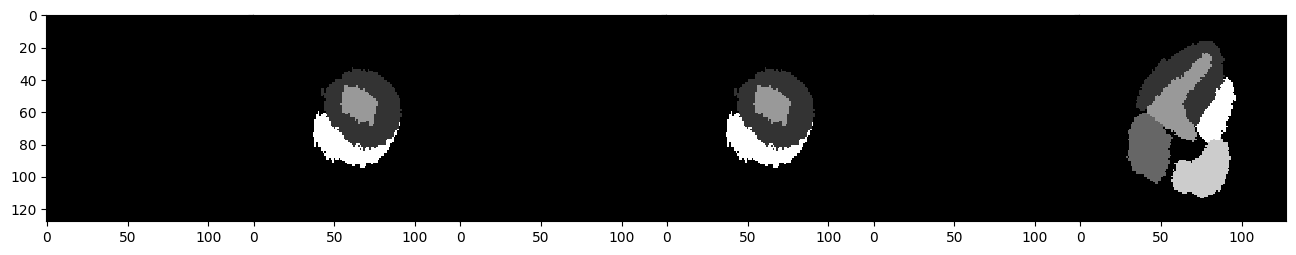

In [30]:
training_dataset.train(augment=False)
training_dataset.self_attributes['augment_angle_std'] = 2
print(training_dataset.do_augment)
for sample in [training_dataset[idx] for idx in [1]]:
    pass
    fig = plt.figure(figsize=(16., 4.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
        nrows_ncols=(1, 6),  # creates 2x2 grid of axes
        axes_pad=0.0,  # pad between axes in inch.
    )

    show_row = [
        cut_slice(sample['image']),
        cut_slice(sample['label']),

        sample['sa_image_slc'],
        sample['sa_label_slc'],

        sample['hla_image_slc'],
        sample['hla_label_slc'],
    ]

    for ax, im in zip(grid, show_row):
        ax.imshow(im, cmap='gray', interpolation='none')

    plt.show()

True


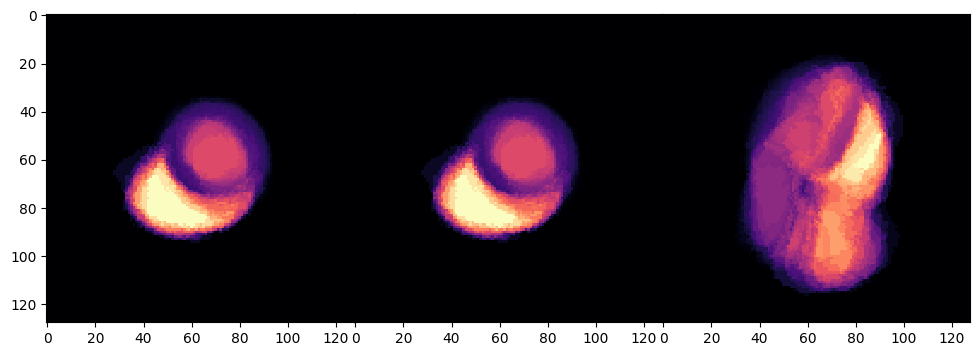

In [6]:
training_dataset.train()
import nibabel as nib
training_dataset.self_attributes['augment_angle_std'] = 10
print(training_dataset.do_augment)
import torch
lbl, sa_label, hla_label = torch.zeros(128,128), torch.zeros(128,128), torch.zeros(128,128)
for idx in range(15):
    sample = training_dataset[1]
    # nib.save(nib.Nifti1Image(sample['label'].cpu().numpy(), affine=torch.eye(4).numpy()), f'out{idx}.nii.gz')
    lbl += cut_slice(sample['label']).cpu()
    sa_label += sample['sa_label_slc'].cpu()
    hla_label += sample['hla_label_slc'].cpu()
fig = plt.figure(figsize=(16., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
    nrows_ncols=(1, 3),  # creates 2x2 grid of axes
    axes_pad=0.0,  # pad between axes in inch.
)

show_row = [
    lbl, sa_label, hla_label
]

for ax, im in zip(grid, show_row):
    ax.imshow(im, cmap='magma', interpolation='none')

plt.show()

False


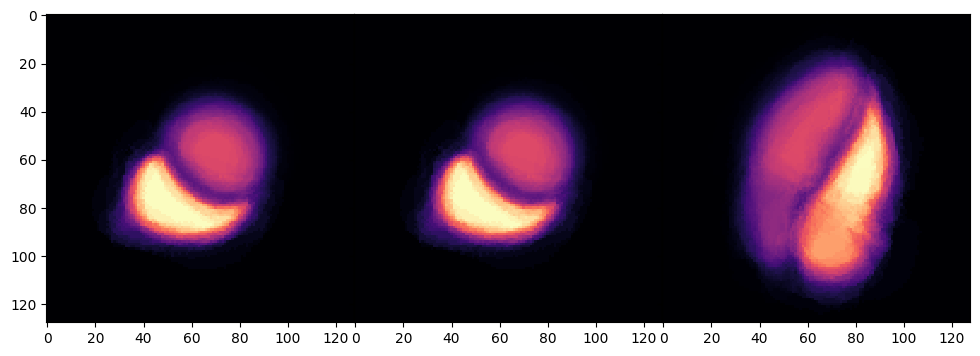

In [31]:
training_dataset.train(augment=False)
training_dataset.self_attributes['augment_angle_std'] = 2
print(training_dataset.do_augment)

lbl, sa_label, hla_label = torch.zeros(128,128), torch.zeros(128,128), torch.zeros(128,128)
for tr_idx in range(len(training_dataset)):
    sample = training_dataset[tr_idx]

    lbl += cut_slice(sample['label']).cpu()
    sa_label += sample['sa_label_slc'].cpu()
    hla_label += sample['hla_label_slc'].cpu()

fig = plt.figure(figsize=(16., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
    nrows_ncols=(1, 3),  # creates 2x2 grid of axes
    axes_pad=0.0,  # pad between axes in inch.
)

show_row = [
    lbl, sa_label, hla_label
]

for ax, im in zip(grid, show_row):
    ax.imshow(im, cmap='magma', interpolation='none')

plt.show()

In [9]:
import contextlib

def get_named_layers_leaves(module):
    """ Returns all leaf layers of a pytorch module and a keychain as identifier.
        e.g.
        ...
        ('features.0.5', nn.ReLU())
        ...
        ('classifier.0', nn.BatchNorm2D())
        ('classifier.1', nn.Linear())
    """

    return [(keychain, sub_mod) for keychain, sub_mod in list(module.named_modules()) if not next(sub_mod.children(), None)]

@contextlib.contextmanager
def temp_forward_hooks(modules, pre_fwd_hook_fn=None, post_fwd_hook_fn=None):
    handles = []
    if pre_fwd_hook_fn:
        handles.extend([mod.register_forward_pre_hook(pre_fwd_hook_fn) for mod in modules])
    if post_fwd_hook_fn:
        handles.extend([mod.register_forward_hook(post_fwd_hook_fn) for mod in modules])

    yield
    for hand in handles:
        hand.remove()
        
def debug_forward_pass(module, inpt, STEP_MODE=False):
    named_leaves = get_named_layers_leaves(module)
    leave_mod_dict = {mod:keychain for keychain, mod in named_leaves}

    def get_shape_str(interface_var):
        if isinstance(interface_var, tuple):
            shps = [str(elem.shape) if isinstance(elem, torch.Tensor) else type(elem) for elem in interface_var]
            return ', '.join(shps)
        elif isinstance(interface_var, torch.Tensor):
            return interface_var.shape
        return type(interface_var)

    def print_pre_info(module, inpt):
        inpt_shapes = get_shape_str(inpt)
        print(f"in:  {inpt_shapes}")
        print(f"key: {leave_mod_dict[module]}")
        print(f"mod: {module}")
        if STEP_MODE:
            input("To continue forward pass press [ENTER]")

    def print_post_info(module, inpt, output):
        output_shapes = get_shape_str(output)
        print(f"out: {output_shapes}\n")

    with temp_forward_hooks(leave_mod_dict.keys(), print_pre_info, print_post_info):
        return module(inpt)

In [10]:
import torch

DEBUG = False

class BlendowskiAE(torch.nn.Module):

    class ConvBlock(torch.nn.Module):
        def __init__(self, in_channels: int, out_channels_list: list, strides_list: list):
            super().__init__()

            ops = []
            in_channels = [in_channels] + out_channels_list[:-1]
            for op_idx in range(len(out_channels_list)):
                ops.append(torch.nn.Conv3d(
                    in_channels[op_idx], 
                    out_channels_list[op_idx], 
                    kernel_size=3, 
                    stride=strides_list[op_idx],
                    padding=1
                ))

            self.block = torch.nn.Sequential(*ops)
        
        def forward(self, x):
            return self.block(x)

        

    def __init__(self, in_channels, out_channels, decoder_in_channels=2):
        super().__init__()    

        self.first_layer_encoder = self.ConvBlock(in_channels, out_channels_list=[8], strides_list=[1])
        self.first_layer_decoder = self.ConvBlock(8, out_channels_list=[8,out_channels], strides_list=[1,1])

        self.second_layer_encoder = self.ConvBlock(8, out_channels_list=[20,20,20], strides_list=[2,1,1])
        self.second_layer_decoder = self.ConvBlock(20, out_channels_list=[8], strides_list=[1])

        self.third_layer_encoder = self.ConvBlock(20, out_channels_list=[40,40,40], strides_list=[2,1,1])
        self.third_layer_decoder = self.ConvBlock(40, out_channels_list=[20], strides_list=[1])

        self.fourth_layer_encoder = self.ConvBlock(40, out_channels_list=[60,60,60], strides_list=[2,1,1])
        self.fourth_layer_decoder = self.ConvBlock(decoder_in_channels, out_channels_list=[40], strides_list=[1])

        self.fifth_layer = self.ConvBlock(60, out_channels_list=[60,20,2], strides_list=[2,1,1])

        self.encoder = torch.nn.Sequential(
            self.first_layer_encoder,
            self.second_layer_encoder,
            self.third_layer_encoder,
            self.fourth_layer_encoder,
            self.fifth_layer
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Upsample(scale_factor=2),
            self.fourth_layer_decoder,
            torch.nn.Upsample(scale_factor=2),
            self.third_layer_decoder,
            torch.nn.Upsample(scale_factor=2),
            self.second_layer_decoder,
            torch.nn.Upsample(scale_factor=2),
            self.first_layer_decoder,
        )

    def encode(self, x):
        if DEBUG:
            return debug_forward_pass(self.encoder, x, STEP_MODE=False)
        else:
            return self.encoder(x)
    
    def decode(self, z):
        if DEBUG:
            return debug_forward_pass(self.decoder, z, STEP_MODE=False)
        else:
            return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z), z
        


class BlendowskiVAE(BlendowskiAE):
    def __init__(self, *args, **kwargs):
        kwargs['decoder_in_channels'] = 1
        super().__init__(*args, **kwargs)

    def sample_z(self, mean, std):
        return torch.normal(mean=mean, std=std).unsqueeze(1)

    def forward(self, x):
        h = self.encode(x)
        z = self.sample_z(h[:,0], (h[:,1]**2).sqrt())
        return self.decode(z), z



In [11]:
x = torch.zeros(1,8,128,128,128)
bae = BlendowskiAE(in_channels=8, out_channels=8)

y, z = bae(x)

print("BAE")
print("x", x.shape)
print("z", z.shape)
print("y", y.shape)
print()

bvae = BlendowskiVAE(in_channels=8, out_channels=8)

y, z = bvae(x)

print("BVAE")
print("x", x.shape)
print("z", z.shape)
print("y", y.shape)


BAE
x torch.Size([1, 8, 128, 128, 128])
z torch.Size([1, 2, 8, 8, 8])
y torch.Size([1, 8, 128, 128, 128])

BVAE
x torch.Size([1, 8, 128, 128, 128])
z torch.Size([1, 1, 8, 8, 8])
y torch.Size([1, 8, 128, 128, 128])


In [32]:
model = BlendowskiVAE(in_channels=6, out_channels=6)
model.cuda()
with torch.no_grad():
    smp = torch.nn.functional.one_hot(training_dataset[1]['label'], 6).unsqueeze(0).permute([0,4,1,2,3]).float().cuda()
y, _ = model(smp)

torch.cuda.memory_allocated()/1024**3

0.03685188293457031